Load control detection using power quality data (feature engineering approach)
------------------------------------------------------------------------------

Two approaches for load control detection - supervised and unsupervised - are implemented in this notebook. As inputs we use power quality characteristics: measurements, estimations, and deviations. Estimations and deviations are created using neural networks, which represents the  "feature engineering" part (here we assume that estimations and deviations are already available after running the script "nowcasting").

In [1]:
import pandas as pd
import numpy as np

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly

In [39]:
# In our study, there are two experiments: for the ventilation system and for the main distribution board
# Here we initialize a variable "exp_name", which is used to define a path to the necessary data, i.e., csv-files, 
# in which power quality measurements, estimates, and deviations are stored

exp_name = 'main_distribution_board_2018_2020' # or exp_name = 'ventilation_system_2018_2020'

In [40]:
pq_inputs = ['TDU', 'ITD', 'Q1act'] # power quality characteristics used as inputs in this analysis
phases = ['L1', 'L2', 'L3'] # data come from the three-phase electricity distribution network 

In [44]:
# Create empty dataframes to store the PQ-input data
df_no_control_2019_2020 = None # There was no load control in winter 2019-2020
df_control_2020_2021 = None  # There was load control in winter 2020-2021

# Import the PQ-inputs from the files (the result of feature engineering)
for i, pq_input in enumerate(pq_inputs):
    for j, phase in enumerate(phases):
        
        df_2019_2020 = pd.read_csv('{}/PQ {} {} 2019_2020.csv'.format(exp_name, pq_input, phase), index_col = 0)
        df_2020_2021 = pd.read_csv('{}/PQ {} {} 2020_2021.csv'.format(exp_name, pq_input, phase), index_col = 0)
        
        df_2019_2020.columns = ['Timestamp', 'measured_{}{}'.format(pq_input, phase), 
                           'estimated_{}{}'.format(pq_input, phase), 'deviation_{}{}'.format(pq_input, phase)]
        df_2020_2021.columns = ['Timestamp', 'measured_{}{}'.format(pq_input, phase), 
                           'estimated_{}{}'.format(pq_input, phase), 'deviation_{}{}'.format(pq_input, phase)]
        
        df_2019_2020.set_index('Timestamp', inplace=True)
        df_2020_2021.set_index('Timestamp', inplace=True)
        
        if i==0 and j==0:
            df_no_control_2019_2020 = pd.DataFrame(index = df_2019_2020.index)
            df_control_2020_2021 = pd.DataFrame(index = df_2020_2021.index)

        df_no_control_2019_2020 = df_no_control_2019_2020.join(df_2019_2020)
        df_control_2020_2021 = df_control_2020_2021.join(df_2020_2021)

        
df_no_control_2019_2020['date'] = pd.DatetimeIndex(df_no_control_2019_2020.index).date
df_control_2020_2021['date'] = pd.DatetimeIndex(df_control_2020_2021.index).date

In [45]:
# Data Transformation: 
# create daily values from 10-min PQ-inputs using mean, max, min, and std 
def create_daily_values(df):
    
    df_mean = df.groupby(['date']).mean()
    df_mean.columns = [col+'_mean' for col in df_mean.columns]

    df_max = df.groupby(['date']).max()
    df_max.columns = [col+'_max' for col in df_max.columns]

    df_min = df.groupby(['date']).min()
    df_min.columns = [col+'_min' for col in df_min.columns]

    df_std = df.groupby(['date']).std()
    df_std.columns = [col+'_std' for col in df_std.columns]

    df_all = df_mean.copy()
    df_all = df_all.join(df_max)
    df_all = df_all.join(df_min)
    df_all = df_all.join(df_std)
    
    return df_all

df_daily_2019_2020 = create_daily_values(df_no_control_2019_2020)
df_daily_2020_2021 = create_daily_values(df_control_2020_2021)

In [47]:
# Add an outcome variable "control"
df_daily_2019_2020['control'] = 0
df_daily_2020_2021['control'] = 1

Supervised learning
-------------------

In [48]:
# Days from Dec 2019 and Dec 2020 are used as the test data
test_data = pd.concat( [df_daily_2019_2020.loc[pd.DatetimeIndex(df_daily_2019_2020.index).month == 12],
                        df_daily_2020_2021.loc[pd.DatetimeIndex(df_daily_2020_2021.index).month == 12]
                       ] )

# Days from Nov, Jan, Feb 2019-2020 and Nov, Jan, Feb 2020-2021 are used as the training data
training_data = pd.concat( [df_daily_2019_2020.loc[pd.DatetimeIndex(df_daily_2019_2020.index).month != 12],
                        df_daily_2020_2021.loc[pd.DatetimeIndex(df_daily_2020_2021.index).month != 12]
                       ] )


In [50]:
# There was one day in Dec 2020 (2020-12-27), when load contol was off
test_data.iloc[57, len(test_data.columns)-1] = 0

In [2]:
# imports for supervised learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

In [18]:
# Drop data lines with missing values, if there are any
training_data_noNan = training_data.dropna()
test_data_noNan = test_data.dropna()

In [19]:
# Train and test Random Forest; examine the model performance in multiple runs 
training_inputs = training_data_noNan.loc[:, training_data_noNan.columns[:-1]]
training_output = training_data_noNan.control.values

test_inputs = test_data_noNan.loc[:, test_data_noNan.columns[:-1]]
test_output = test_data_noNan.control.values

rf_results = pd.DataFrame(columns = ['run', 'depth', 'train_acc', 'valid_acc', 'test_acc'])

runs = 25
# Tune the max tree depth on the validation data
depths = [1,2,3,4,5,7,10,13,15,18,20,22,25]

for depth in depths:
    for run in range(runs):
                
        acc_train = 0
        acc_valid = 0
        acc_test = 0
        
        model = RandomForestClassifier(max_depth = depth, n_estimators = 100)

        # Validation
        n_splits = 5
        cv = StratifiedShuffleSplit(n_splits=n_splits)
        for train_index, valid_index in cv.split(training_inputs, training_output):

            train_x = training_inputs.iloc[train_index]
            train_y = training_output[train_index]

            valid_x = training_inputs.iloc[valid_index]
            valid_y = training_output[valid_index]

            model.fit(train_x, train_y.ravel())
            predictions_valid = model.predict(valid_x)
            acc_valid = acc_valid + accuracy_score(valid_y, predictions_valid)/n_splits

        # Training
        model.fit(training_inputs, training_output)
        predictions_train = model.predict(training_inputs)
        acc_train = accuracy_score(training_output, predictions_train)
        
        # Testing
        predictions_test = model.predict(test_inputs)
        acc_test = accuracy_score(test_output, predictions_test)
        
        rf_results = rf_results.append({'run': run, 'depth': depth, 
                                        'train_acc': acc_train, 'valid_acc': acc_valid, 'test_acc': acc_test}, ignore_index = True)

In [21]:
# Find the best "max tree depth" values based on the validation performance
depth_opt = rf_results.groupby(['depth']).mean().index[rf_results.groupby(['depth']).mean()['valid_acc'].argmax()]

In [22]:
# Test performance in multiple runs
test_accuracy = rf_results.loc[rf_results.loc[:, 'depth'] == depth_opt, 'test_acc'].values
print("Average test performance: {}".format(sum(test_accuracy)/len(test_accuracy)))

In [25]:
# Train Random Forest with the optimized "max tree depth" multiple times to analyze variable importances
training_inputs = training_data_noNan.loc[:, training_data_noNan.columns[:-1]]
training_output = training_data_noNan.control.values

test_inputs = test_data_noNan.loc[:, test_data_noNan.columns[:-1]]
test_output = test_data_noNan.control.values

runs = 100
    
rf_predictions = pd.DataFrame(columns = ['predictions_{}'.format(run) for run in range(runs)], index = test_inputs.index)
rf_importance = pd.DataFrame(columns = ['importance_{}'.format(run) for run in range(runs)], index = test_inputs.columns)


for run in range(runs):

    model = RandomForestClassifier(max_depth = depth_opt)

    # Training
    model.fit(training_inputs, training_output)
    predictions_train = model.predict(training_inputs)

    # Testing
    predictions_test = model.predict(test_inputs)
    
    rf_predictions.loc[:, 'predictions_{}'.format(run)] = predictions_test
    rf_importance.loc[:, 'importance_{}'.format(run)] = model.feature_importances_


In [31]:
# Importance
top_10 = (rf_importance.sum(axis = 1)/runs).to_frame(name = 'importance').sort_values('importance', ascending = False).head(10)

Unsupervised learning
---------------------

In [57]:
# In the unsupervised scenario, days from Dec 2020 are used to test the model;
# days from Dec 2019 are used to validate the model;
# days from Nov, Jan, Feb 2019-2020 are used to train the model

test_data = pd.concat( [df_daily_2020_2021.loc[pd.DatetimeIndex(df_daily_2020_2021.index).month == 12]
                     ] )

validation_data = pd.concat( [df_daily_2019_2020.loc[pd.DatetimeIndex(df_daily_2019_2020.index).month == 12]
                           ] )

training_data = pd.concat( [df_daily_2019_2020.loc[pd.DatetimeIndex(df_daily_2019_2020.index).month != 12]
                           ] )


In [58]:
# There was one day in Dec 2020 (2020-12-27), when load contol was off
test_data.iloc[26, len(test_data.columns)-1] = 0

In [59]:
# Drop data lines with missing values; separate inputs and outputs
training_data_noNan = training_data.dropna()
validation_data_noNan = validation_data.dropna()
test_data_noNan = test_data.dropna()

training_inputs = training_data_noNan.loc[:, training_data_noNan.columns[:-1]]
training_output = training_data_noNan.control.values

validation_inputs = validation_data_noNan.loc[:, validation_data_noNan.columns[:-1]]
validation_output = validation_data_noNan.control.values

test_inputs = test_data_noNan.loc[:, test_data_noNan.columns[:-1]]
test_output = test_data_noNan.control.values


In [60]:
# When running the experiments in the supervised scenario, we found out that 
# mean and max deviations are the most informative variables

if exp_name == 'main_distribution_board_2018_2020' # or exp_name = 'ventilation_system_2018_2020'
    columns_selected = [col for col in test_inputs.columns if 'deviation' in col and 'mean' in col 
                       ] + [col for col in test_inputs.columns if 'deviation' in col and 'max' in col]

if exp_name == 'ventilation_system_2018_2020'
    columns_selected = [col for col in test_inputs.columns if 'deviation' in col and 'mean' in col]
                

In [61]:
# Train the Isolation Forest model that returns anomaly scores (in several independent runs)
# Use the validation data to adjust the threshold (i.e., 'percentile')
# Estimate anomaly scores for the test data; return the final binary predictions (anomaly or not, i.e., control or not)

from sklearn.ensemble import IsolationForest

df = pd.DataFrame(columns = ['run', 'percentile', 'acc_test', 'acc_valid'])

runs=25

training_scores = np.zeros(training_inputs.shape[0])
validation_scores = np.zeros(validation_inputs.shape[0])
test_scores = np.zeros(test_inputs.shape[0])

for r in range(runs):
    clf = IsolationForest().fit(training_inputs.loc[:, columns_selected])

    training_scores = training_scores + clf.score_samples(training_inputs.loc[:, columns_selected])/runs
    validation_scores = validation_scores + clf.score_samples(validation_inputs.loc[:, columns_selected])/runs
    test_scores = test_scores + clf.score_samples(test_inputs.loc[:, columns_selected])/runs
        
for percentile in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    threshold = np.percentile(training_scores, percentile)

    predictions_validation = [1 if score<threshold else 0 for score in validation_scores]
    acc_valid = 1 - np.abs(predictions_validation - validation_output).sum()/len(predictions_validation)

    predictions_test = [1 if score<threshold else 0 for score in test_scores]
    acc_test = 1 - np.abs(predictions_test - test_output).sum()/len(predictions_test)

    df = df.append({'run': r, 'percentile': percentile, 'acc_test': acc_test, 'acc_valid': acc_valid}, ignore_index = True)

In [62]:
df_average = df.groupby(['percentile']).mean()
df_average = df_average.drop('run', axis = 1).reset_index()

# Define the threshold as the maximum percentile value that leads to 100%-accuracy on the validation data
# There are several very low anomaly scores for the training data; 
# if there are outliers in the training data, this strategy helps deal with them
percentile = df_average.loc[max(list(df_average.index[(df_average.loc[:, "acc_valid"] == 1.0)])), "percentile"]
threshold_opt = np.percentile(training_scores, percentile)

In [63]:
# Average test performance
test_accuracy = df_average.loc[ df_average.loc[:, 'percentile'] == percentile, 'test_acc' ]

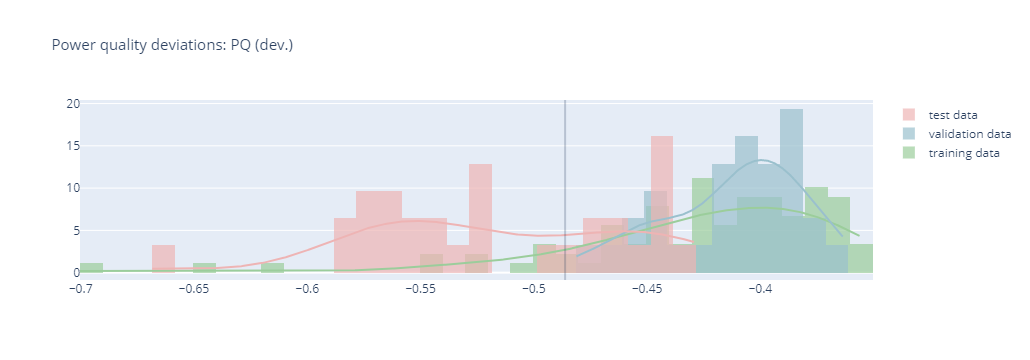

In [68]:
# Visualize distributions of anomaly scores for the training, validation, and test data

import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
import numpy as np

hist_data = [training_scores, validation_scores, test_scores]
group_labels = ['training data', 'validation data', 'test data'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels, curve_type='kde', colors = ['RGB(155,205,155)', 'RGB(154,192,205)', 'RGB(238,180,180)'],
                         show_rug=False, bin_size = 0.01)

fig.update_layout(barmode='overlay', 
    title={'text':'Power quality deviations: PQ (dev.)', 'font':{'size':15}})

fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0=0, y1=1,
      xref= 'x', x0= threshold_opt, x1= threshold_opt,
      fillcolor = 'gray', opacity = 0.25
    )
])


fig.update_layout(height=350, width=900)

fig.show()